In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
data = pd.read_csv('Influenza_Surveillance_Weekly_-_Historical.csv')
print(data.head())


   MMWR_WEEK  WEEK_START    WEEK_END FLU_RISK_LEVEL INFLUENZA_SEASON  \
0     202401  12/31/2023  01/06/2024           HIGH        2023-2024   
1     202438  09/15/2024  09/21/2024            LOW        2023-2024   
2     202427  06/30/2024  07/06/2024            LOW        2023-2024   
3     202306  02/05/2023  02/11/2023     DECREASING        2022-2023   
4     202307  02/12/2023  02/18/2023     DECREASING        2022-2023   

   HOSP_FLU_ICU_WEEKLY  HOSP_FLU_ICU_CUMULATIVE  LAB_FLU_TESTED  \
0                   27                      155            6761   
1                    0                      302            2512   
2                    1                      300            1973   
3                    2                      191            4475   
4                    2                      193            4496   

   LAB_FLU_POSITIVE  LAB_FLU_PCT_POSITIVE  ...  LAB_TOT_POSITIVE_CUMULATIVE  \
0               785                  0.12  ...                         4918   
1     

In [3]:
data['WEEK_START'] = pd.to_datetime(data['WEEK_START'])
data['WEEK_END'] = pd.to_datetime(data['WEEK_END'])

sorted_data = data.sort_values('WEEK_START')

filter_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2025-12-31')
sorted_filtered_data = sorted_data[sorted_data['WEEK_START'] >= filter_date] # Filter data from 2021 onwards
print(sorted_filtered_data.tail())


    MMWR_WEEK WEEK_START   WEEK_END FLU_RISK_LEVEL INFLUENZA_SEASON  \
13     202435 2024-08-25 2024-08-31            LOW        2023-2024   
14     202436 2024-09-01 2024-09-07            LOW        2023-2024   
15     202437 2024-09-08 2024-09-14            LOW        2023-2024   
1      202438 2024-09-15 2024-09-21            LOW        2023-2024   
10     202439 2024-09-22 2024-09-28            LOW        2023-2024   

    HOSP_FLU_ICU_WEEKLY  HOSP_FLU_ICU_CUMULATIVE  LAB_FLU_TESTED  \
13                    0                      300            2100   
14                    1                      301            2097   
15                    1                      302            2679   
1                     0                      302            2512   
10                    0                      302            2341   

    LAB_FLU_POSITIVE  LAB_FLU_PCT_POSITIVE  ...  LAB_TOT_POSITIVE_CUMULATIVE  \
13                 7                   0.0  ...                        11277   
14  

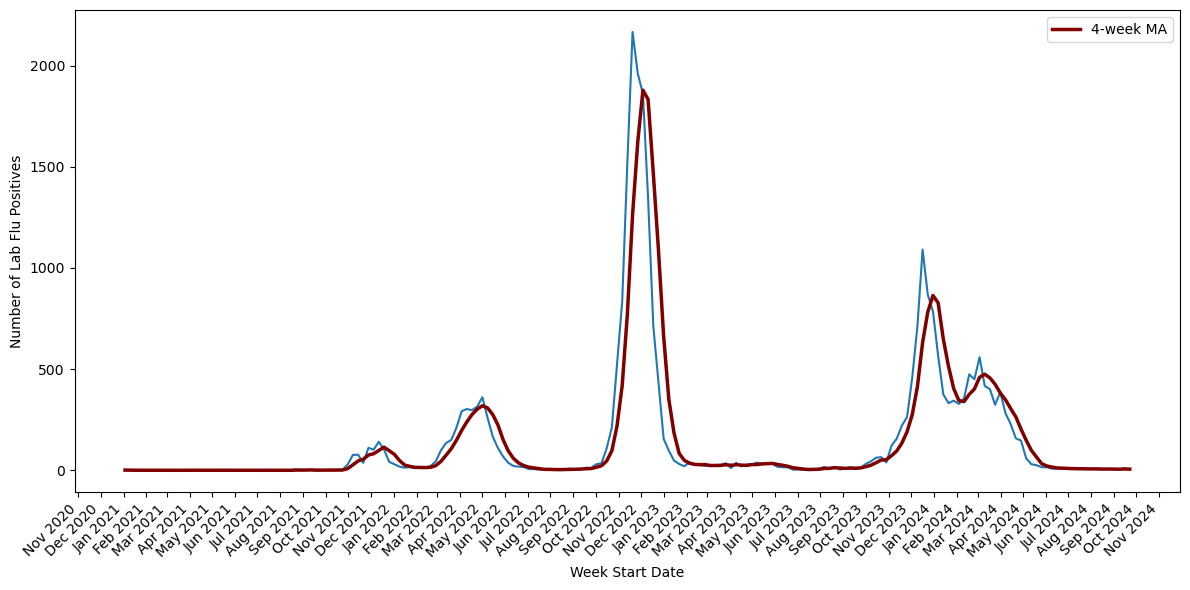

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sorted_filtered_data['WEEK_START'], sorted_filtered_data['LAB_FLU_POSITIVE'])
plt.xlabel('Week Start Date')


plt.ylabel('Number of Lab Flu Positives')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
plt.xticks(rotation=45, ha='right', )
plt.tight_layout()

#Plot a moving average
ma_window = 4
weekly_positive = sorted_filtered_data.set_index('WEEK_START')['LAB_FLU_POSITIVE']

moving_avg = weekly_positive.rolling(window=ma_window, min_periods=1).mean()
ax.plot(moving_avg.index, moving_avg.values, color='maroon', linewidth=2.5, label=f'{ma_window}-week MA', zorder=3)
ax.legend()
plt.show()



In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# series to model: weekly_positive (already available)
y = weekly_positive.copy()

# define seasonal period for weekly data with yearly seasonality (52 weeks)
s = 52

# chosen SARIMA order (can be tuned or replaced with auto_arima if available)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, s)

# fit model
model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
res = model.fit()

# build forecast index through end of 2026 (weekly frequency aligned to series)
start_forecast = y.index[-1] + pd.Timedelta(days=7)
end_forecast = pd.to_datetime('2026-12-31')
future_idx = pd.date_range(start=start_forecast, end=end_forecast, freq='7D')

# produce forecasts with confidence intervals
pred = res.get_forecast(steps=len(future_idx))
forecast = pd.Series(pred.predicted_mean.values, index=future_idx)
ci = pred.conf_int(alpha=0.05)
ci.index = future_idx

c:\Users\apcoc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\apcoc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\apcoc\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\apcoc\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


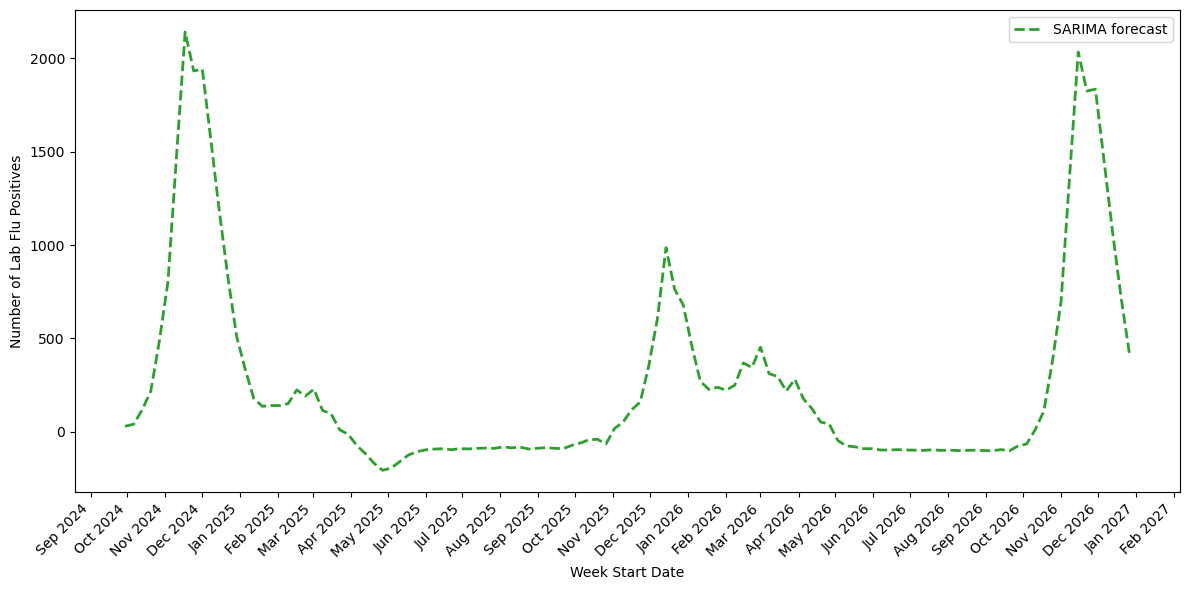

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(forecast.index, forecast.values, color='tab:green', linestyle='--', linewidth=2, label='SARIMA forecast')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
plt.xticks(rotation=45, ha='right', )
plt.ylabel('Number of Lab Flu Positives')
plt.xlabel('Week Start Date')
plt.tight_layout()
plt.show()

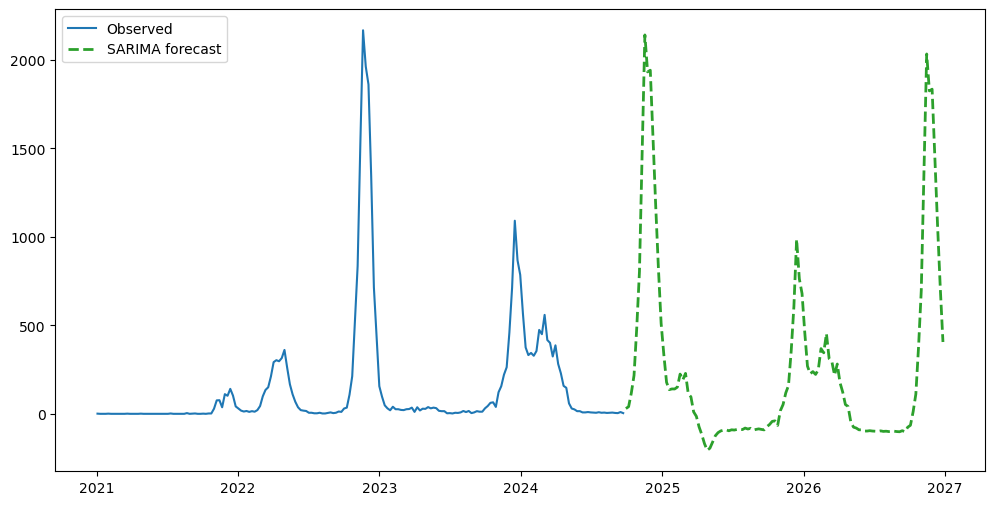

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(sorted_filtered_data['WEEK_START'], sorted_filtered_data['LAB_FLU_POSITIVE'], label='Observed', zorder=2)
ax.plot(forecast.index, forecast.values, color='tab:green', linestyle='--', linewidth=2, label='SARIMA forecast', zorder=3)
ax.legend()
